In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
from DomainPrediction.protein.base import BaseProtein
from DomainPrediction.protein.base import FoldedProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools
from DomainPrediction.utils.tmalign import TMalign
from DomainPrediction.utils.constants import *
from DomainPrediction.esm.esm2 import ESM2

In [4]:
root = '../..'
data_path = os.path.join(root, 'Data/round_2_exp')
gxps_path = os.path.join(root, 'Data/gxps')

#### Load ESM2

In [10]:
esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt')

#### Round 1 setup

First we need to merge the A and C domains of round 1 extractions and create a fasta file \
For metadata - compute perplexity, add titer values and seq ID to wild type \
Create basis plots for perplexity and seq id

In [ ]:
# gxps_wt_seq = helper.read_fasta(os.path.join(gxps_path, 'GxpS_ATC.fasta'), mode='str')[0]
# gxps_wt_protein = BaseProtein(sequence=gxps_wt_seq, id='gxps_wt')

In [ ]:
# ## Merging A and C domains to extraction of round 1 fasta
# records = helper.read_fasta(os.path.join(data_path, 'round_1_extraction.fasta'))
# for rec in records:
#     helper.create_fasta(sequences={
#         rec.id: gxps_wt_protein.get_residues(A_gxps_atc) + str(rec.seq) + gxps_wt_protein.get_residues(C_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'round_1.fasta'),
#     append=True)

In [ ]:
# ## Creating a fasta file of T domains
# records = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
# for rec in records:
#     protein = BaseProtein(sequence=str(rec.seq), id=rec.id)
#     helper.create_fasta(sequences={
#         rec.id: protein.get_residues(T_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'round_1.T.fasta'),
#     append=True)

In [ ]:
# ## Seq ID to WT xgps and save to metadata
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(gxps_path, 'GxpS.T.fasta'),
#     gen = os.path.join(data_path, 'round_1.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )
# records = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
# meta_file = os.path.join(os.path.join(data_path, 'round_1_metadata.json'))
# for rec, seq_id in zip(records, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_WT(T)', seq_id, force=False)

Perplexity calculation in the cluster : use the following code block

```python
meta_file = os.path.join(os.path.join(data_path, 'round_1_metadata.json'))
records = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
for rec in records:
    perplexity = metrics.compute_perplexity(esm2, str(rec.seq))

    print(rec.id, perplexity)
    helper.update_metadata_json(meta_file, rec.id, 'esm2_650M_perplexity', perplexity, force=False)
```

In [ ]:
# ## Adding titer values to metadata
# titers = [0.041674705, 0.032554255, 0.062307446, 0.003060206, 0.020001747, 0, 0, 0.015385128, 0, 0, 0.003624185, 0]
# records = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
# meta_file = os.path.join(os.path.join(data_path, 'round_1_metadata.json'))
# for rec, seq_id in zip(records, titers):
#     helper.update_metadata_json(meta_file, rec.id, 'titer', seq_id, force=False)

#### Round 1 Analysis

In [ ]:
meta_file = os.path.join(os.path.join(data_path, 'round_1_metadata.json'))
with open(meta_file) as f:
    round_1_meta = json.load(f)
df_meta = pd.DataFrame(round_1_meta).T

In [ ]:
width = 0.25  # the width of the bars
multiplier = 0
x = np.arange(df_meta.shape[0])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), layout='constrained')
for col in ['titer', 'seq_id_WT(T)']:
    offset = width*multiplier
    if col == 'titer':
        rects = ax[0].bar(x + offset, df_meta[col], width, label=col)
        ax[0].bar_label(rects, padding=3, size=7, fmt=f'%.3f', rotation='vertical', annotation_clip=True)
    else:
        ax2 = ax[0].twinx()
        rects = ax[0].bar(x + offset, 0, width, label=col) ## trck tro bring labels
        rects = ax2.bar(x + offset, df_meta[col], width, label=col, color='tab:orange')
        ax2.bar_label(rects, padding=3, size=7, fmt=f'%.3f', rotation='vertical', annotation_clip=True)

    multiplier += 1
ax[0].set_ylim((0, 0.08))    
ax2.set_ylim((0, 1.2))
ax[0].set_ylabel('titer (TIC normalize)')
ax2.set_ylabel('seq id to WT')
ax[0].set_xticks(x + width, df_meta.index, size=8, rotation=45)
ax[0].legend()

ax[1].plot(df_meta.loc[['ESM' in i for i in df_meta['titer'].index], 'seq_id_WT(T)'], df_meta.loc[['ESM' in i for i in df_meta['titer'].index], 'titer'], 'o', label='ESM3')
mpnn_mask = np.array(['IN' in i for i in df_meta['titer'].index])
ax[1].plot(df_meta.loc[mpnn_mask & (df_meta['titer'] > 0), 'seq_id_WT(T)'], df_meta.loc[mpnn_mask & (df_meta['titer'] > 0), 'titer'], 'o', label='MPNN titer > 0')
ax[1].plot(df_meta.loc[mpnn_mask & ~(df_meta['titer'] > 0), 'seq_id_WT(T)'], df_meta.loc[mpnn_mask & ~(df_meta['titer'] > 0), 'titer'], 'o', label='MPNN titer = 0')
ax[1].axhline(y=df_meta.loc['PC-GxpS_ATC', 'titer'], ls='--', label='PC/WT', color='tab:red')
ax[1].set_ylabel('titer (TIC normalize)')
ax[1].set_xlabel('seq id to WT')
ax[1].legend()

plt.show()

In [ ]:
width = 0.25  # the width of the bars
multiplier = 0
x = np.arange(df_meta.shape[0])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), layout='constrained')
for col in ['titer', 'esm2_650M_perplexity']:
    offset = width*multiplier
    if col == 'titer':
        rects = ax[0].bar(x + offset, df_meta[col], width, label=col)
        ax[0].bar_label(rects, padding=3, size=6, fmt=f'%.3f', rotation='vertical', annotation_clip=True)
    else:
        ax2 = ax[0].twinx()
        rects = ax[0].bar(x + offset, 0, width, label=col) ## trck tro bring labels
        rects = ax2.bar(x + offset, df_meta[col], width, label=col, color='tab:orange')
        ax2.bar_label(rects, padding=3, size=6, fmt=f'%.3f', rotation='vertical', annotation_clip=True)

    multiplier += 1
ax[0].set_ylim((0, 0.08))    
ax2.set_ylim((4, 5.5))
ax[0].set_ylabel('titer (TIC normalize)')
ax2.set_ylabel('perplexity')
ax[0].set_xticks(x + width, df_meta.index, size=8, rotation=45)
ax[0].legend()

ax[1].plot(df_meta.loc[['ESM' in i for i in df_meta['titer'].index], 'esm2_650M_perplexity'], df_meta.loc[['ESM' in i for i in df_meta['titer'].index], 'titer'], 'o', label='ESM3')
mpnn_mask = np.array(['IN' in i for i in df_meta['titer'].index])
ax[1].plot(df_meta.loc[mpnn_mask & (df_meta['titer'] > 0), 'esm2_650M_perplexity'], df_meta.loc[mpnn_mask & (df_meta['titer'] > 0), 'titer'], 'o', label='MPNN titer > 0')
ax[1].plot(df_meta.loc[mpnn_mask & ~(df_meta['titer'] > 0), 'esm2_650M_perplexity'], df_meta.loc[mpnn_mask & ~(df_meta['titer'] > 0), 'titer'], 'o', label='MPNN titer = 0')
ax[1].plot(df_meta.loc['PC-GxpS_ATC', 'esm2_650M_perplexity'], df_meta.loc['PC-GxpS_ATC', 'titer'], 'o', label='PC/WT', color='tab:red')
ax[1].set_ylabel('titer (TIC normalize)')
ax[1].set_xlabel('esm2 650M perplexity')
ax[1].legend()

plt.show()

#### 

#### ESM3 and EvoDiff Sequences setup

Perplexity is calculated like above and added to metadata \
Add seq id to wt and best working seq to metadata \
Clustering using Kmeans and adding cluster ids to metadata \
Should we also cluster the round 1 sequences ? - maybe once we fix which model we use \
Train a RF model ontop of embeddings and add predicted Titers to metatdata

In [ ]:
## Get WildType Protein
gxps_wt_seq = helper.read_fasta(os.path.join(gxps_path, 'GxpS_ATC.fasta'), mode='str')[0]
gxps_wt_protein = BaseProtein(sequence=gxps_wt_seq, id='gxps_wt')

In [ ]:
## Get The best working protein
round1_best_seq = helper.read_fasta(os.path.join(data_path, 'round1.best.fasta'), mode='str')[0]
round1_best_protein = BaseProtein(sequence=round1_best_seq, id='round1.best')

In [ ]:
esm3_fasta = os.path.join(data_path, 'esm3_400.fasta')
esm3_sequences = helper.read_fasta(esm3_fasta)
esm3_str_fasta = os.path.join(data_path, 'esm3_str_400.fasta')
esm3_str_sequences = helper.read_fasta(esm3_str_fasta)
evodiff_fasta = os.path.join(data_path, 'evodiff_400.fasta')
evodiff_sequences = helper.read_fasta(evodiff_fasta)

In [ ]:
len(esm3_sequences), len(esm3_str_sequences), len(evodiff_sequences), len(esm3_sequences[0].seq), len(esm3_str_sequences[0].seq), len(evodiff_sequences[0].seq)

In [ ]:
# ## Creating a fasta file of T domains

# for rec in esm3_sequences:
#     protein = BaseProtein(sequence=str(rec.seq), id=rec.id)
#     helper.create_fasta(sequences={
#         rec.id: protein.get_residues(T_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'esm3_400.T.fasta'),
#     append=True)

# for rec in esm3_str_sequences:
#     protein = BaseProtein(sequence=str(rec.seq), id=rec.id)
#     helper.create_fasta(sequences={
#         rec.id: protein.get_residues(T_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'esm3_str_400.T.fasta'),
#     append=True)

# for rec in evodiff_sequences:
#     protein = BaseProtein(sequence=str(rec.seq), id=rec.id)
#     helper.create_fasta(sequences={
#         rec.id: protein.get_residues(T_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'evodiff_400.T.fasta'),
#     append=True)

In [ ]:
# ## Seq ID to WT xgps and save to metadata : ESM3
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(gxps_path, 'GxpS.T.fasta'),
#     gen = os.path.join(data_path, 'esm3_400.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )

# meta_file = os.path.join(os.path.join(data_path, 'esm3_400_metadata.json'))
# for rec, seq_id in zip(esm3_sequences, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_WT(T)', seq_id, force=False)

In [ ]:
# ## Seq ID to WT xgps and save to metadata : ESM3 structure
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(gxps_path, 'GxpS.T.fasta'),
#     gen = os.path.join(data_path, 'esm3_str_400.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )

# meta_file = os.path.join(os.path.join(data_path, 'esm3_str_400_metadata.json'))
# for rec, seq_id in zip(esm3_str_sequences, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_WT(T)', seq_id, force=False)

In [ ]:
# ## Seq ID to WT xgps and save to metadata : EvoDiff
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(gxps_path, 'GxpS.T.fasta'),
#     gen = os.path.join(data_path, 'evodiff_400.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )

# meta_file = os.path.join(os.path.join(data_path, 'evodiff_400_metadata.json'))
# for rec, seq_id in zip(evodiff_sequences, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_WT(T)', seq_id, force=False)

In [ ]:
# ## Seq ID to best round 1 seq and save to metadata : ESM3
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(data_path, 'round1.best.T.fasta'),
#     gen = os.path.join(data_path, 'esm3_400.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )

# meta_file = os.path.join(os.path.join(data_path, 'esm3_400_metadata.json'))
# for rec, seq_id in zip(esm3_sequences, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_best_r1(T)', seq_id, force=False)

In [ ]:
# ## Seq ID to best round 1 seq and save to metadata : ESM3 structure
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(data_path, 'round1.best.T.fasta'),
#     gen = os.path.join(data_path, 'esm3_str_400.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )

# meta_file = os.path.join(os.path.join(data_path, 'esm3_str_400_metadata.json'))
# for rec, seq_id in zip(esm3_str_sequences, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_best_r1(T)', seq_id, force=False)

In [ ]:
# ## Seq ID to best round 1 seq and save to metadata : EvoDiff
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(data_path, 'round1.best.T.fasta'),
#     gen = os.path.join(data_path, 'evodiff_400.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )

# meta_file = os.path.join(os.path.join(data_path, 'evodiff_400_metadata.json'))
# for rec, seq_id in zip(evodiff_sequences, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_best_r1(T)', seq_id, force=False)

K means cluster assignment

In [ ]:
def get_embeddings_rec(sequences):
    embeddings = []
    for rec in tqdm(sequences):
        seq = ''.join([rec.seq[i] for i in range(len(rec.seq)) if i not in A_gxps_atc + C_gxps_atc])
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

def get_embeddings_seq(sequences):
    embeddings = []
    for seq in tqdm(sequences):
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

In [ ]:
# esm3_embeddings = get_embeddings_rec(esm3_sequences)
# esm3_str_embeddings = get_embeddings_rec(esm3_str_sequences)
# evodiff_embeddings = get_embeddings_rec(evodiff_sequences)

In [ ]:
# kmeans = KMeans(n_clusters=8, random_state=0, max_iter=1000)
# esm3_clusters = kmeans.fit_predict(esm3_embeddings)
# esm3_str_clusters = kmeans.fit_predict(esm3_str_embeddings)
# evodiff_clusters = kmeans.fit_predict(evodiff_embeddings)

In [ ]:
# pca = PCA(n_components=2)

# fig, ax = plt.subplots(1,3, figsize=(9,3), layout="constrained")

# reduced_embeddings = pca.fit_transform(esm3_embeddings)
# ax[0].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=esm3_clusters)

# reduced_embeddings = pca.fit_transform(esm3_str_embeddings)
# ax[1].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=esm3_str_clusters)

# reduced_embeddings = pca.fit_transform(evodiff_embeddings)
# ax[2].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=evodiff_clusters)
# # ax[1].set_xlim(right=0.5)
# plt.show()

In [ ]:
# ## update cluster idx to meta
# meta_file = os.path.join(os.path.join(data_path, 'esm3_400_metadata.json'))
# for rec, c_idx in zip(esm3_sequences, esm3_clusters):
#     helper.update_metadata_json(meta_file, rec.id, 'cluster_id', int(c_idx), force=False)

# meta_file = os.path.join(os.path.join(data_path, 'esm3_str_400_metadata.json'))
# for rec, c_idx in zip(esm3_str_sequences, esm3_str_clusters):
#     helper.update_metadata_json(meta_file, rec.id, 'cluster_id', int(c_idx), force=False)

# meta_file = os.path.join(os.path.join(data_path, 'evodiff_400_metadata.json'))
# for rec, c_idx in zip(evodiff_sequences, evodiff_clusters):
#     helper.update_metadata_json(meta_file, rec.id, 'cluster_id', int(c_idx), force=False)

Build RF regressor for round 1 sequences and save pred titers to meta

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None, min_samples_split=2,
#                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0,
#                                 max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,
#                                 n_jobs=None, random_state=1, verbose=0, warm_start=False, ccp_alpha=0.0,
#                                 max_samples=None)

In [ ]:
# round_1_sequences = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
# with open(os.path.join(data_path, 'round_1_metadata.json')) as f:
#     round_1_meta = json.load(f)
# round_1_meta = pd.DataFrame(round_1_meta).T
# y = round_1_meta['titer'].to_numpy()
# mask = y > 0
# round_1_embeddings = get_embeddings_rec(round_1_sequences)
# _ = model.fit(round_1_embeddings[mask], y[mask])

# plt.figure()
# plt.plot(y[mask], model.predict(round_1_embeddings[mask]), '.')
# plt.show()

In [ ]:
# esm3_pred_titer = model.predict(esm3_embeddings)
# esm3_str_pred_titer = model.predict(esm3_str_embeddings)
# evodiff_pred_titer = model.predict(evodiff_embeddings)

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize=(9,3))
# ax[0].hist(esm3_pred_titer)
# ax[1].hist(esm3_str_pred_titer)
# ax[2].hist(evodiff_pred_titer)
# plt.show()

In [ ]:
# ## update pred titer to meta
# meta_file = os.path.join(os.path.join(data_path, 'esm3_400_metadata.json'))
# assert len(esm3_sequences) == len(esm3_pred_titer)
# for rec, titer in zip(esm3_sequences, esm3_pred_titer):
#     helper.update_metadata_json(meta_file, rec.id, 'pred_titer', titer, force=False)

# meta_file = os.path.join(os.path.join(data_path, 'esm3_str_400_metadata.json'))
# assert len(esm3_str_sequences) == len(esm3_str_pred_titer)
# for rec, titer in zip(esm3_str_sequences, esm3_str_pred_titer):
#     helper.update_metadata_json(meta_file, rec.id, 'pred_titer', titer, force=False)

# meta_file = os.path.join(os.path.join(data_path, 'evodiff_400_metadata.json'))
# for rec, titer in zip(evodiff_sequences, evodiff_pred_titer):
#     helper.update_metadata_json(meta_file, rec.id, 'pred_titer', titer, force=False)

#### ESM3 and EvoDiff Analysis and plots

In [5]:
## Get WildType Protein
gxps_wt_seq = helper.read_fasta(os.path.join(gxps_path, 'GxpS_ATC.fasta'), mode='str')[0]
gxps_wt_protein = BaseProtein(sequence=gxps_wt_seq, id='gxps_wt')

In [6]:
## Get The best working protein
round1_best_seq = helper.read_fasta(os.path.join(data_path, 'round1.best.fasta'), mode='str')[0]
round1_best_protein = BaseProtein(sequence=round1_best_seq, id='round1.best')

In [7]:
esm3_fasta = os.path.join(data_path, 'esm3_400.fasta')
esm3_sequences = helper.read_fasta(esm3_fasta)
esm3_str_fasta = os.path.join(data_path, 'esm3_str_400.fasta')
esm3_str_sequences = helper.read_fasta(esm3_str_fasta)
evodiff_fasta = os.path.join(data_path, 'evodiff_400.fasta')
evodiff_sequences = helper.read_fasta(evodiff_fasta)

In [11]:
def get_embeddings_rec(sequences):
    embeddings = []
    for rec in tqdm(sequences):
        seq = ''.join([rec.seq[i] for i in range(len(rec.seq)) if i not in A_gxps_atc + C_gxps_atc])
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

def get_embeddings_seq(sequences):
    embeddings = []
    for seq in tqdm(sequences):
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

In [12]:
esm3_embeddings = get_embeddings_rec(esm3_sequences)
esm3_str_embeddings = get_embeddings_rec(esm3_str_sequences)
evodiff_embeddings = get_embeddings_rec(evodiff_sequences)

100%|██████████| 400/400 [03:18<00:00,  2.02it/s]


In [13]:
with open(os.path.join(data_path, 'esm3_400_metadata.json')) as f:
    esm3_meta = json.load(f)
esm3_meta = pd.DataFrame(esm3_meta).T

with open(os.path.join(data_path, 'esm3_str_400_metadata.json')) as f:
    esm3_str_meta = json.load(f)
esm3_str_meta = pd.DataFrame(esm3_str_meta).T

with open(os.path.join(data_path, 'evodiff_400_metadata.json')) as f:
    evodiff_meta = json.load(f)
evodiff_meta = pd.DataFrame(evodiff_meta).T

In [14]:
esm3_proteins = {}
for rec in esm3_sequences:
    esm3_proteins[rec.id] = BaseProtein(sequence=str(rec.seq), id=rec.id)

esm3_str_proteins = {}
for rec in esm3_str_sequences:
    esm3_str_proteins[rec.id] = BaseProtein(sequence=str(rec.seq), id=rec.id)

evodiff_proteins = {}
for rec in evodiff_sequences:
    evodiff_proteins[rec.id] = BaseProtein(sequence=str(rec.seq), id=rec.id)

In [15]:
import re
def search_and_filter_motif(records, pattern: str = 'FF.{2}GGHS'):
    '''
        Extend to list of sequences or dict?
        Extend to save list to fasta or return selected sequences
    '''
    matches = []
    for rec in records:
        if re.search(pattern, str(rec.seq)):
            matches.append(rec.id)
    
    # print(f'{len(matches)*100/len(records)}% records contain motif')

    return matches

In [16]:
esm3_meta['motif'] = False
esm3_meta.loc[search_and_filter_motif(esm3_sequences), 'motif'] = True
print(f"motif present in {esm3_meta['motif'].sum()} of {esm3_meta.shape[0]}")

motif present in 275 of 400


In [17]:
esm3_str_meta['motif'] = False
esm3_str_meta.loc[search_and_filter_motif(esm3_str_sequences), 'motif'] = True
print(f"motif present in {esm3_str_meta['motif'].sum()} of {esm3_str_meta.shape[0]}")

motif present in 380 of 400


In [18]:
evodiff_meta['motif'] = False
evodiff_meta.loc[search_and_filter_motif(evodiff_sequences), 'motif'] = True
print(f"motif present in {evodiff_meta['motif'].sum()} of {evodiff_meta.shape[0]}")

motif present in 385 of 400


In [19]:
print(f"max titer for esm3 : {esm3_meta['pred_titer'].max()}")
print(esm3_meta.loc[esm3_meta['pred_titer'].idxmax()])

max titer for esm3 : 0.03680695011000002
esm2_650M_perplexity    4.609207
seq_id_WT(T)            0.485714
seq_id_best_r1(T)       0.585714
cluster_id                   6.0
pred_titer              0.036807
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_333, dtype: object


no of proteins in cluster 0.0: 70
no of proteins in cluster 0.0 with motif: 55
no of proteins for cluster 0.0 after filtering: 26
max titer before filter : 0.03275231420000001
max titer after filter : 0.03275231420000001
selected seq: gxps_ATC_esm3_temp_0.5_gen_385
esm2_650M_perplexity    4.667936
seq_id_WT(T)            0.457143
seq_id_best_r1(T)       0.542857
cluster_id                   0.0
pred_titer              0.032752
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_385, dtype: object
T domain: TPLEQQLAEIWAELLGLDRVGVHDNFFELGGHSILAVQLMARVRTQLGVELPVRSLFETPTIAGLAARLQ


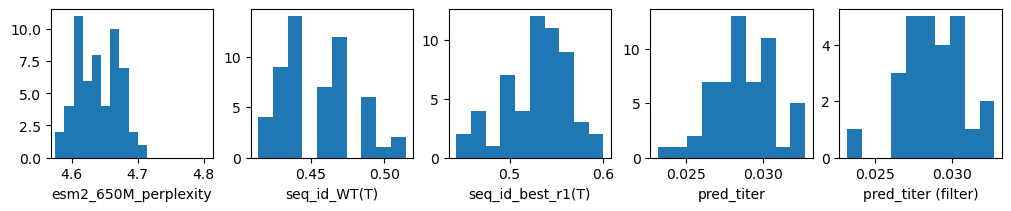

no of proteins in cluster 1.0: 46
no of proteins in cluster 1.0 with motif: 37
no of proteins for cluster 1.0 after filtering: 18
max titer before filter : 0.03558496784000001
max titer after filter : 0.03494925865
selected seq: gxps_ATC_esm3_temp_0.5_gen_93
esm2_650M_perplexity    4.645105
seq_id_WT(T)            0.457143
seq_id_best_r1(T)       0.514286
cluster_id                   1.0
pred_titer              0.034949
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_93, dtype: object
T domain: DLEQQLAQLWADVLGVERVGRHDNFFDLGGHSILSIRLVSRIRSQLGVELPLRTLFDAPTVAELAQRIEQ


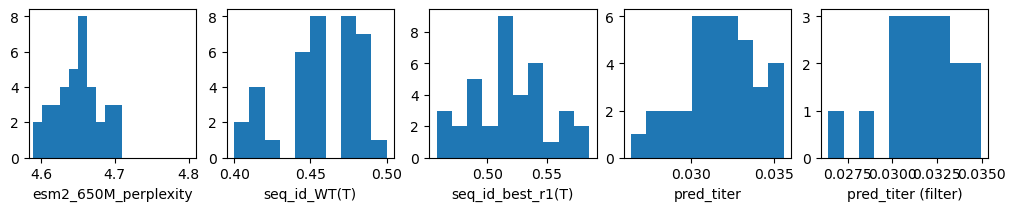

no of proteins in cluster 2.0: 48
no of proteins in cluster 2.0 with motif: 39
no of proteins for cluster 2.0 after filtering: 14
max titer before filter : 0.03251713748
max titer after filter : 0.03251713748
selected seq: gxps_ATC_esm3_temp_0.5_gen_104
esm2_650M_perplexity    4.663397
seq_id_WT(T)            0.457143
seq_id_best_r1(T)       0.542857
cluster_id                   2.0
pred_titer              0.032517
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_104, dtype: object
T domain: TPAEEILAGIWQEVLGLERIGIHDNFFELGGHSILAVRVMSRIRQALGVELPVRSLFEAPTIAELAALID


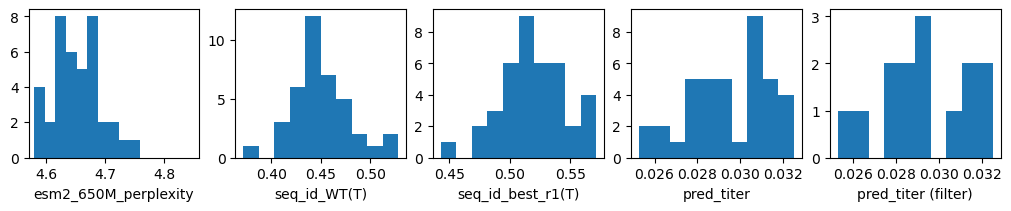

no of proteins in cluster 3.0: 36
no of proteins in cluster 3.0 with motif: 19
no of proteins for cluster 3.0 after filtering: 8
max titer before filter : 0.03466296565000001
max titer after filter : 0.033069774510000004
selected seq: gxps_ATC_esm3_temp_0.5_gen_192
esm2_650M_perplexity    4.638739
seq_id_WT(T)            0.457143
seq_id_best_r1(T)       0.557143
cluster_id                   3.0
pred_titer               0.03307
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_192, dtype: object
T domain: TPTEEVLAAIWADVLGLERVGIHDNFFELGGHSILATQVIARVRATFGLELPVRALFEAPTIAGLAARLD


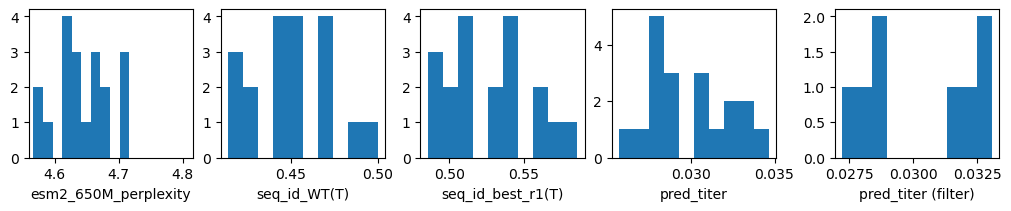

no of proteins in cluster 4.0: 36
no of proteins in cluster 4.0 with motif: 26
no of proteins for cluster 4.0 after filtering: 10
max titer before filter : 0.032960709140000016
max titer after filter : 0.031118300809999996
selected seq: gxps_ATC_esm3_temp_0.5_gen_35
esm2_650M_perplexity    4.704042
seq_id_WT(T)            0.471429
seq_id_best_r1(T)       0.557143
cluster_id                   4.0
pred_titer              0.031118
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_35, dtype: object
T domain: TPTEQILAQIWAELLGLERVGIHDNFFELGGHSILAIQLVSRLRQVFGIELPVRTLFEAPTIAQQAALVD


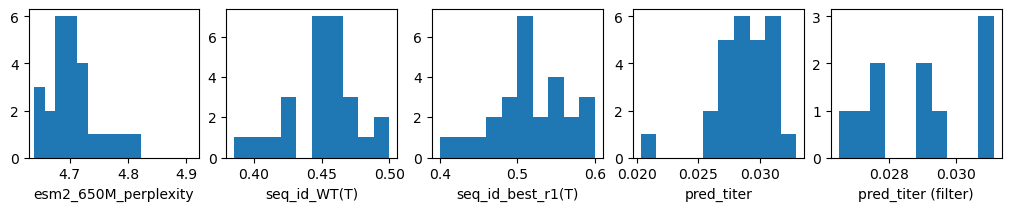

no of proteins in cluster 5.0: 59
no of proteins in cluster 5.0 with motif: 31
no of proteins for cluster 5.0 after filtering: 14
max titer before filter : 0.03317060781
max titer after filter : 0.03317060781
selected seq: gxps_ATC_esm3_temp_0.5_gen_17
esm2_650M_perplexity    4.687471
seq_id_WT(T)            0.528571
seq_id_best_r1(T)       0.514286
cluster_id                   5.0
pred_titer              0.033171
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_17, dtype: object
T domain: TEVEQTLAGIWAELLGVEQVGIHDNFFDLGGHSILAVQMIARIRTALGVDVPVRALFEAPTIAELATQVD


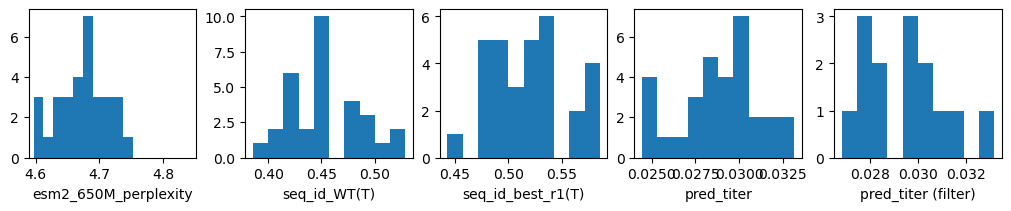

no of proteins in cluster 6.0: 19
no of proteins in cluster 6.0 with motif: 14
no of proteins for cluster 6.0 after filtering: 6
max titer before filter : 0.03680695011000002
max titer after filter : 0.03680695011000002
selected seq: gxps_ATC_esm3_temp_0.5_gen_333
esm2_650M_perplexity    4.609207
seq_id_WT(T)            0.485714
seq_id_best_r1(T)       0.585714
cluster_id                   6.0
pred_titer              0.036807
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_333, dtype: object
T domain: TTLEEQLASIWSELLQRERVGIHDNFFELGGHSLLATQLIARIRSTFGVELPLRTLFEAPTIAELARRLE


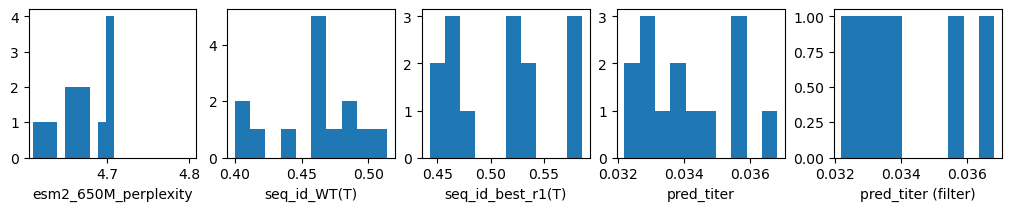

no of proteins in cluster 7.0: 86
no of proteins in cluster 7.0 with motif: 54
no of proteins for cluster 7.0 after filtering: 19
max titer before filter : 0.033010574060000006
max titer after filter : 0.03194833155000001
selected seq: gxps_ATC_esm3_temp_0.5_gen_124
esm2_650M_perplexity    4.671471
seq_id_WT(T)            0.471429
seq_id_best_r1(T)       0.542857
cluster_id                   7.0
pred_titer              0.031948
motif                       True
Name: gxps_ATC_esm3_temp_0.5_gen_124, dtype: object
T domain: TATEETLADIWAELLGVDRVGIHDNFFELGGHSLLAVQLIARVRTVFAVELPLRRLFEAPTIAGLAAHIE


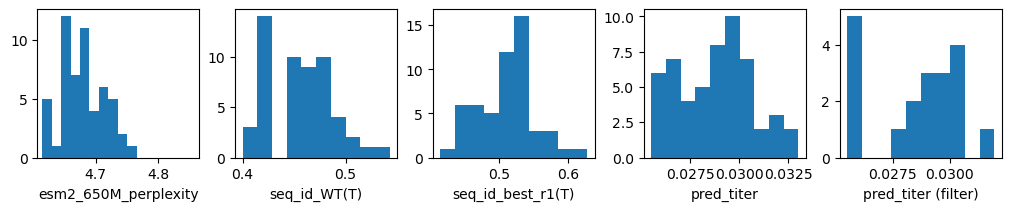

In [20]:
esm3_selected = []
for c_idx in sorted(esm3_meta['cluster_id'].unique()):
    mask = esm3_meta['cluster_id'] == c_idx
    print(f'no of proteins in cluster {c_idx}: {mask.sum()}')
    mask = mask & (esm3_meta['motif'])
    print(f'no of proteins in cluster {c_idx} with motif: {mask.sum()}')

    fig, ax = plt.subplots(1, 5, figsize=(10,2), layout='constrained')
    for _i, col in enumerate(['esm2_650M_perplexity', 'seq_id_WT(T)', 'seq_id_best_r1(T)', 'pred_titer']):
        ax[_i].hist(esm3_meta.loc[mask, col])
        ax[_i].set_xlabel(col)
        if col == 'esm2_650M_perplexity':
            ax[_i].set_xlim(right=esm3_meta.loc[mask, col].max()+0.1)

    perplexity_cutoff = 4.8
    _mask = mask & ((esm3_meta['seq_id_WT(T)'] > 0.45) & (esm3_meta['seq_id_best_r1(T)'] > 0.5))
    _mask = _mask & (esm3_meta['esm2_650M_perplexity'] < perplexity_cutoff)
    print(f'no of proteins for cluster {c_idx} after filtering: {_mask.sum()}')

    ax[4].hist(esm3_meta.loc[_mask, 'pred_titer'])
    ax[4].set_xlabel('pred_titer (filter)')

    print(f"max titer before filter : {esm3_meta.loc[mask, 'pred_titer'].max()}")
    print(f"max titer after filter : {esm3_meta.loc[_mask, 'pred_titer'].max()}")

    select = esm3_meta.loc[_mask, 'pred_titer'].idxmax()
    print(f'selected seq: {select}')
    print(esm3_meta.loc[select])
    print(f'T domain: {esm3_proteins[select].get_residues(T_gxps_atc)}')

    esm3_selected.append(select)

    plt.show()

In [21]:
esm3_selected

['gxps_ATC_esm3_temp_0.5_gen_385',
 'gxps_ATC_esm3_temp_0.5_gen_93',
 'gxps_ATC_esm3_temp_0.5_gen_104',
 'gxps_ATC_esm3_temp_0.5_gen_192',
 'gxps_ATC_esm3_temp_0.5_gen_35',
 'gxps_ATC_esm3_temp_0.5_gen_17',
 'gxps_ATC_esm3_temp_0.5_gen_333',
 'gxps_ATC_esm3_temp_0.5_gen_124']

In [22]:
print(gxps_wt_protein.get_residues(T_gxps_atc))
print(round1_best_protein.get_residues(T_gxps_atc))
print(' ')
for i in esm3_selected:
    print(esm3_proteins[i].get_residues(T_gxps_atc))

GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP
GETEQLLAGIWMDLLQVDRVGRHDSFFELGGHSLLAVRLLGRLRQHGLGLQMRDLFEAPVLAELATRLRP
 
TPLEQQLAEIWAELLGLDRVGVHDNFFELGGHSILAVQLMARVRTQLGVELPVRSLFETPTIAGLAARLQ
DLEQQLAQLWADVLGVERVGRHDNFFDLGGHSILSIRLVSRIRSQLGVELPLRTLFDAPTVAELAQRIEQ
TPAEEILAGIWQEVLGLERIGIHDNFFELGGHSILAVRVMSRIRQALGVELPVRSLFEAPTIAELAALID
TPTEEVLAAIWADVLGLERVGIHDNFFELGGHSILATQVIARVRATFGLELPVRALFEAPTIAGLAARLD
TPTEQILAQIWAELLGLERVGIHDNFFELGGHSILAIQLVSRLRQVFGIELPVRTLFEAPTIAQQAALVD
TEVEQTLAGIWAELLGVEQVGIHDNFFDLGGHSILAVQMIARIRTALGVDVPVRALFEAPTIAELATQVD
TTLEEQLASIWSELLQRERVGIHDNFFELGGHSLLATQLIARIRSTFGVELPLRTLFEAPTIAELARRLE
TATEETLADIWAELLGVDRVGIHDNFFELGGHSLLAVQLIARVRTVFAVELPLRRLFEAPTIAGLAAHIE


In [31]:
esm3_selected = ['gxps_ATC_esm3_temp_0.5_gen_385',
 'gxps_ATC_esm3_temp_0.5_gen_93',
#  'gxps_ATC_esm3_temp_0.5_gen_104',
 'gxps_ATC_esm3_temp_0.5_gen_192',
#  'gxps_ATC_esm3_temp_0.5_gen_35',
 'gxps_ATC_esm3_temp_0.5_gen_17',
 'gxps_ATC_esm3_temp_0.5_gen_333',
#  'gxps_ATC_esm3_temp_0.5_gen_124'
]

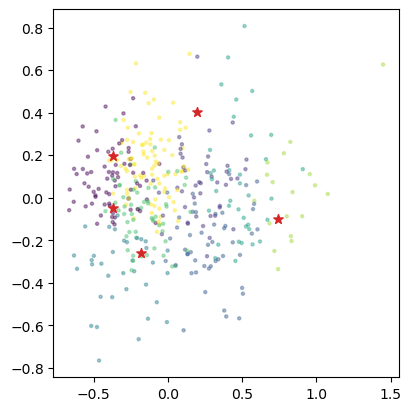

In [32]:
pca = PCA(n_components=2)

fig, ax = plt.subplots(1,1, figsize=(4,4), layout="constrained")
reduced_embeddings = pca.fit_transform(esm3_embeddings)
ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=esm3_meta['cluster_id'], alpha=0.4)
mask = esm3_meta.index.isin(esm3_selected)
ax.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], s=50, c='tab:red', marker='*')
plt.show()

In [38]:
# ## Save to fasta
# save_fasta_file = os.path.join(data_path, 'round_2.fasta')
# for rec_id in esm3_selected:
#     print(rec_id)
#     helper.create_fasta({
#         rec_id: esm3_proteins[rec_id].sequence
#     },
#     file=save_fasta_file,
#     append=True)

gxps_ATC_esm3_temp_0.5_gen_385
gxps_ATC_esm3_temp_0.5_gen_93
gxps_ATC_esm3_temp_0.5_gen_192
gxps_ATC_esm3_temp_0.5_gen_17
gxps_ATC_esm3_temp_0.5_gen_333


In [39]:
print(f"max titer for esm3 structure : {esm3_str_meta['pred_titer'].max()}")
print(esm3_str_meta.loc[esm3_str_meta['pred_titer'].idxmax()])

max titer for esm3 structure : 0.03967584606000003
esm2_650M_perplexity    4.656102
seq_id_WT(T)            0.542857
seq_id_best_r1(T)       0.728571
cluster_id                   3.0
pred_titer              0.039676
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_365, dtype: object


no of proteins in cluster 0.0: 61
no of proteins in cluster 0.0 with motif: 58
no of proteins for cluster 0.0 after filtering: 58
max titer before filter : 0.03732339206000001
max titer after filter : 0.03732339206000001
selected seq: gxps_ATC_esm3_str_temp_0.5_gen_323
esm2_650M_perplexity    4.658942
seq_id_WT(T)            0.557143
seq_id_best_r1(T)       0.671429
cluster_id                   0.0
pred_titer              0.037323
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_323, dtype: object
T domain: GEVELTLASIWQDLLQVDRVGRHDNFFDLGGHSLLAIQLLSRLRKRGWGLEARDLFEHPVLADLAQRVVP


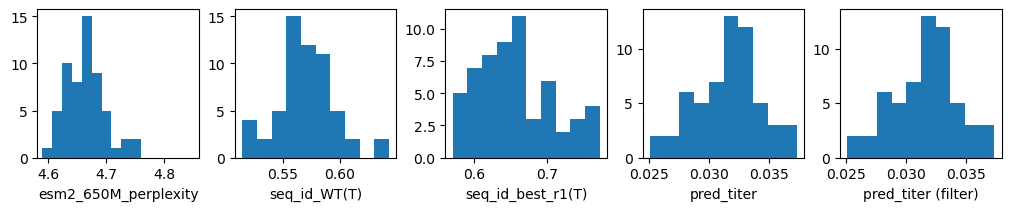

no of proteins in cluster 1.0: 60
no of proteins in cluster 1.0 with motif: 57
no of proteins for cluster 1.0 after filtering: 57
max titer before filter : 0.03889403550000003
max titer after filter : 0.03889403550000003
selected seq: gxps_ATC_esm3_str_temp_0.5_gen_348
esm2_650M_perplexity    4.646291
seq_id_WT(T)                 0.6
seq_id_best_r1(T)       0.771429
cluster_id                   1.0
pred_titer              0.038894
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_348, dtype: object
T domain: GETEQLLASIWQELLQVEQVGRHDNFFELGGHSLLAIRMLARLRQHGLGLRMRDLFQHPVLAELAERITT


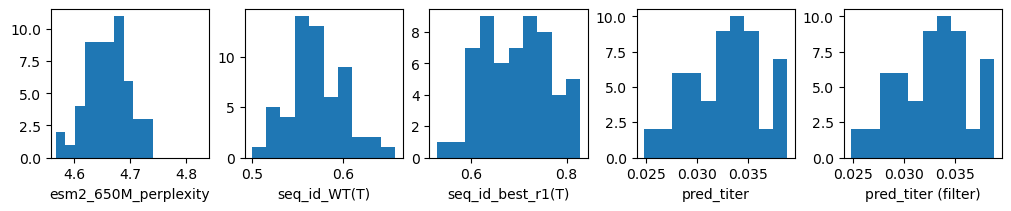

no of proteins in cluster 2.0: 57
no of proteins in cluster 2.0 with motif: 53
no of proteins for cluster 2.0 after filtering: 53
max titer before filter : 0.038969237240000024
max titer after filter : 0.038969237240000024
selected seq: gxps_ATC_esm3_str_temp_0.5_gen_226
esm2_650M_perplexity    4.623817
seq_id_WT(T)                 0.6
seq_id_best_r1(T)       0.657143
cluster_id                   2.0
pred_titer              0.038969
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_226, dtype: object
T domain: GEVEQTLASIWQDLLKVERVGRHDNFFELGGHSLLAVQMLSRLRQQGLGLRLRDLFQHPVLSDLAALLTP


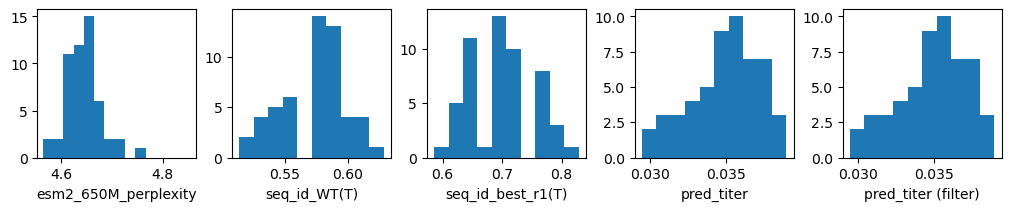

no of proteins in cluster 3.0: 32
no of proteins in cluster 3.0 with motif: 30
no of proteins for cluster 3.0 after filtering: 30
max titer before filter : 0.03967584606000003
max titer after filter : 0.03967584606000003
selected seq: gxps_ATC_esm3_str_temp_0.5_gen_365
esm2_650M_perplexity    4.656102
seq_id_WT(T)            0.542857
seq_id_best_r1(T)       0.728571
cluster_id                   3.0
pred_titer              0.039676
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_365, dtype: object
T domain: GETEQLLAQIWQELLQVEQVGRQDNFFELGGHSLLAIQMLARLRQQGLALALRDLFEHPVLAELAERITP


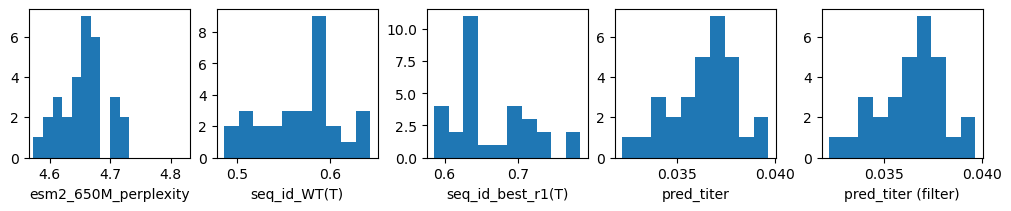

no of proteins in cluster 4.0: 36
no of proteins in cluster 4.0 with motif: 34
no of proteins for cluster 4.0 after filtering: 34
max titer before filter : 0.03598640670000002
max titer after filter : 0.03598640670000002
selected seq: gxps_ATC_esm3_str_temp_0.5_gen_314
esm2_650M_perplexity    4.602972
seq_id_WT(T)                 0.6
seq_id_best_r1(T)            0.7
cluster_id                   4.0
pred_titer              0.035986
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_314, dtype: object
T domain: GETETLLATIWQELLGVDRVGRQDNFFDLGGHSLLAVRLLSRLRRHGWGLALRDLFEHPVLAELAGRLTP


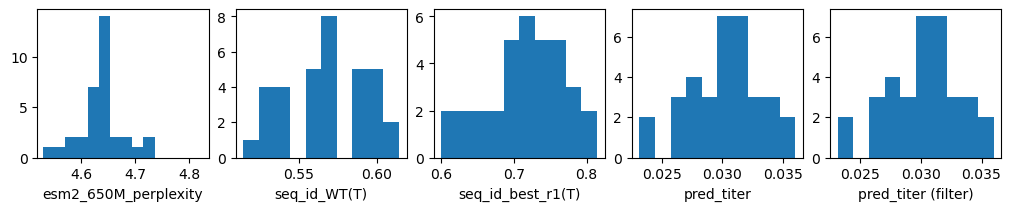

no of proteins in cluster 5.0: 42
no of proteins in cluster 5.0 with motif: 40
no of proteins for cluster 5.0 after filtering: 40
max titer before filter : 0.03699884406000002
max titer after filter : 0.03699884406000002
selected seq: gxps_ATC_esm3_str_temp_0.5_gen_53
esm2_650M_perplexity    4.649825
seq_id_WT(T)            0.585714
seq_id_best_r1(T)       0.771429
cluster_id                   5.0
pred_titer              0.036999
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_53, dtype: object
T domain: GETEQLLASIWQELLQVERVGRHDNFFDLGGHSLLAVRMLSRLRQHGLGLSLRSLFEQPVLAELAAALTE


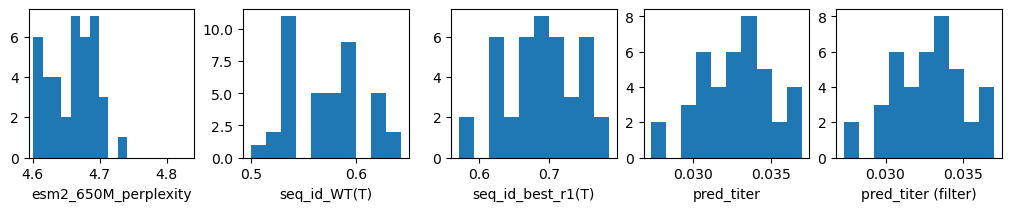

no of proteins in cluster 6.0: 47
no of proteins in cluster 6.0 with motif: 47
no of proteins for cluster 6.0 after filtering: 47
max titer before filter : 0.03966433929000003
max titer after filter : 0.03966433929000003
selected seq: gxps_ATC_esm3_str_temp_0.5_gen_346
esm2_650M_perplexity    4.674918
seq_id_WT(T)            0.557143
seq_id_best_r1(T)            0.7
cluster_id                   6.0
pred_titer              0.039664
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_346, dtype: object
T domain: GETEQLLAGIWQELLEVEQVGRHDNFFELGGHSLLALQMLARLREHGLSLSLRALFETPVLAELAAQVTQ


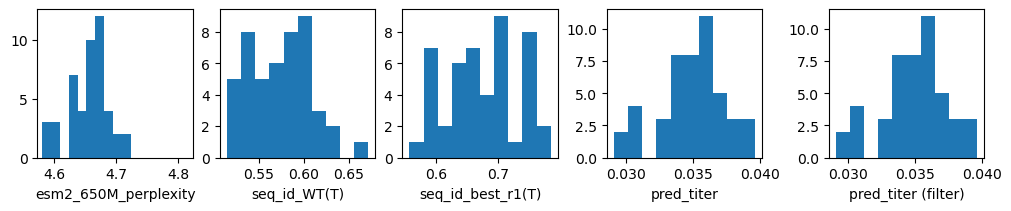

no of proteins in cluster 7.0: 65
no of proteins in cluster 7.0 with motif: 61
no of proteins for cluster 7.0 after filtering: 61
max titer before filter : 0.039616666180000024
max titer after filter : 0.039616666180000024
selected seq: gxps_ATC_esm3_str_temp_0.5_gen_170
esm2_650M_perplexity    4.610719
seq_id_WT(T)            0.614286
seq_id_best_r1(T)       0.642857
cluster_id                   7.0
pred_titer              0.039617
motif                       True
Name: gxps_ATC_esm3_str_temp_0.5_gen_170, dtype: object
T domain: GPVEQTLATIWQELLEVEQVGRHDSFFDLGGHSLLAVQMLARLRSQGLQLELRDLFEHPVLAELAQRIEP


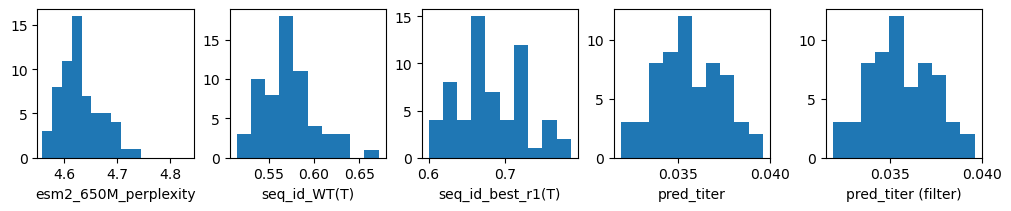

In [40]:
esm3_str_selected = []
for c_idx in sorted(esm3_str_meta['cluster_id'].unique()):
    mask = esm3_str_meta['cluster_id'] == c_idx
    print(f'no of proteins in cluster {c_idx}: {mask.sum()}')
    mask = mask & (esm3_str_meta['motif'])
    print(f'no of proteins in cluster {c_idx} with motif: {mask.sum()}')

    fig, ax = plt.subplots(1, 5, figsize=(10,2), layout='constrained')
    for _i, col in enumerate(['esm2_650M_perplexity', 'seq_id_WT(T)', 'seq_id_best_r1(T)', 'pred_titer']):
        ax[_i].hist(esm3_str_meta.loc[mask, col])
        ax[_i].set_xlabel(col)
        if col == 'esm2_650M_perplexity':
            ax[_i].set_xlim(right=esm3_str_meta.loc[mask, col].max()+0.1)

    perplexity_cutoff = 4.8
    _mask = mask & ((esm3_str_meta['seq_id_WT(T)'] > 0.45) & (esm3_str_meta['seq_id_best_r1(T)'] > 0.5))
    _mask = _mask & (esm3_str_meta['esm2_650M_perplexity'] < perplexity_cutoff)
    print(f'no of proteins for cluster {c_idx} after filtering: {_mask.sum()}')

    ax[4].hist(esm3_str_meta.loc[_mask, 'pred_titer'])
    ax[4].set_xlabel('pred_titer (filter)')

    print(f"max titer before filter : {esm3_str_meta.loc[mask, 'pred_titer'].max()}")
    print(f"max titer after filter : {esm3_str_meta.loc[_mask, 'pred_titer'].max()}")

    select = esm3_str_meta.loc[_mask, 'pred_titer'].idxmax()
    print(f'selected seq: {select}')
    print(esm3_str_meta.loc[select])
    print(f'T domain: {esm3_str_proteins[select].get_residues(T_gxps_atc)}')

    esm3_str_selected.append(select)

    plt.show()

In [41]:
esm3_str_selected

['gxps_ATC_esm3_str_temp_0.5_gen_323',
 'gxps_ATC_esm3_str_temp_0.5_gen_348',
 'gxps_ATC_esm3_str_temp_0.5_gen_226',
 'gxps_ATC_esm3_str_temp_0.5_gen_365',
 'gxps_ATC_esm3_str_temp_0.5_gen_314',
 'gxps_ATC_esm3_str_temp_0.5_gen_53',
 'gxps_ATC_esm3_str_temp_0.5_gen_346',
 'gxps_ATC_esm3_str_temp_0.5_gen_170']

In [42]:
print(gxps_wt_protein.get_residues(T_gxps_atc))
print(round1_best_protein.get_residues(T_gxps_atc))
print(' ')
for i in esm3_str_selected:
    print(esm3_str_proteins[i].get_residues(T_gxps_atc))

GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP
GETEQLLAGIWMDLLQVDRVGRHDSFFELGGHSLLAVRLLGRLRQHGLGLQMRDLFEAPVLAELATRLRP
 
GEVELTLASIWQDLLQVDRVGRHDNFFDLGGHSLLAIQLLSRLRKRGWGLEARDLFEHPVLADLAQRVVP
GETEQLLASIWQELLQVEQVGRHDNFFELGGHSLLAIRMLARLRQHGLGLRMRDLFQHPVLAELAERITT
GEVEQTLASIWQDLLKVERVGRHDNFFELGGHSLLAVQMLSRLRQQGLGLRLRDLFQHPVLSDLAALLTP
GETEQLLAQIWQELLQVEQVGRQDNFFELGGHSLLAIQMLARLRQQGLALALRDLFEHPVLAELAERITP
GETETLLATIWQELLGVDRVGRQDNFFDLGGHSLLAVRLLSRLRRHGWGLALRDLFEHPVLAELAGRLTP
GETEQLLASIWQELLQVERVGRHDNFFDLGGHSLLAVRMLSRLRQHGLGLSLRSLFEQPVLAELAAALTE
GETEQLLAGIWQELLEVEQVGRHDNFFELGGHSLLALQMLARLREHGLSLSLRALFETPVLAELAAQVTQ
GPVEQTLATIWQELLEVEQVGRHDSFFDLGGHSLLAVQMLARLRSQGLQLELRDLFEHPVLAELAQRIEP


In [72]:
esm3_str_selected = [
 'gxps_ATC_esm3_str_temp_0.5_gen_323',
#  'gxps_ATC_esm3_str_temp_0.5_gen_348',
#  'gxps_ATC_esm3_str_temp_0.5_gen_226',
 'gxps_ATC_esm3_str_temp_0.5_gen_365',
 'gxps_ATC_esm3_str_temp_0.5_gen_314',
 'gxps_ATC_esm3_str_temp_0.5_gen_53',
#  'gxps_ATC_esm3_str_temp_0.5_gen_346',
 'gxps_ATC_esm3_str_temp_0.5_gen_170'
 ]

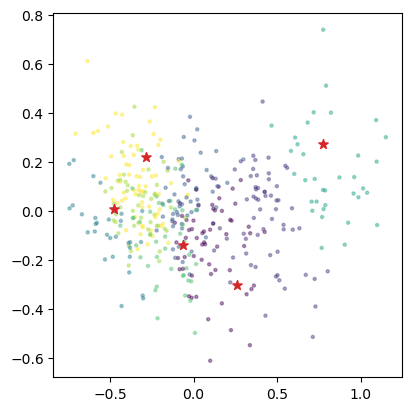

In [73]:
pca = PCA(n_components=2)

fig, ax = plt.subplots(1,1, figsize=(4,4), layout="constrained")
reduced_embeddings = pca.fit_transform(esm3_str_embeddings)
ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=esm3_str_meta['cluster_id'], alpha=0.4)
mask = esm3_str_meta.index.isin(esm3_str_selected)
ax.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], s=50, c='tab:red', marker='*')
plt.show()

In [74]:
# ## Save to fasta
# save_fasta_file = os.path.join(data_path, 'round_2.fasta')
# for rec_id in esm3_str_selected:
#     print(rec_id)
#     helper.create_fasta({
#         rec_id: esm3_str_proteins[rec_id].sequence
#     },
#     file=save_fasta_file,
#     append=True)

gxps_ATC_esm3_str_temp_0.5_gen_323
gxps_ATC_esm3_str_temp_0.5_gen_365
gxps_ATC_esm3_str_temp_0.5_gen_314
gxps_ATC_esm3_str_temp_0.5_gen_53
gxps_ATC_esm3_str_temp_0.5_gen_170


In [75]:
print(f"max titer for evodiff : {evodiff_meta['pred_titer'].max()}")
print(evodiff_meta.loc[evodiff_meta['pred_titer'].idxmax()])

max titer for evodiff : 0.03900948814000003
esm2_650M_perplexity    4.796669
seq_id_WT(T)            0.642857
seq_id_best_r1(T)            0.6
cluster_id                   4.0
pred_titer              0.039009
motif                       True
Name: gxps_ATC_evodiff_gen_21, dtype: object


no of proteins for cluster 0.0: 50
no of proteins in cluster 0.0 with motif: 47
no of proteins for cluster 0.0 after filtering: 10
max titer before filter : 0.03307547593
max titer after filter : 0.03108540321
selected seq: gxps_ATC_evodiff_gen_357
esm2_650M_perplexity    4.879103
seq_id_WT(T)            0.571429
seq_id_best_r1(T)       0.514286
cluster_id                   0.0
pred_titer              0.031085
motif                       True
Name: gxps_ATC_evodiff_gen_357, dtype: object
T domain: DAVETTLASIWSDLLNVEQVGRHDNFFALGGHSLLAVKLIERMRQADLQAAVSVLFNSSSLSALAQTLGS


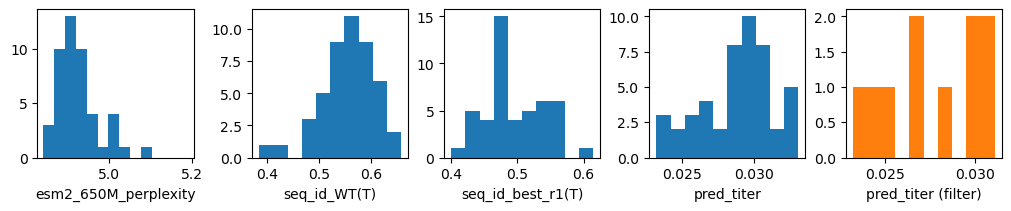

no of proteins for cluster 1.0: 4
no of proteins in cluster 1.0 with motif: 0
Skippping cluster 1.0
 
no of proteins for cluster 2.0: 46
no of proteins in cluster 2.0 with motif: 46
no of proteins for cluster 2.0 after filtering: 29
max titer before filter : 0.03595289769000003
max titer after filter : 0.03595289769000003
selected seq: gxps_ATC_evodiff_gen_77
esm2_650M_perplexity    4.764401
seq_id_WT(T)            0.571429
seq_id_best_r1(T)       0.557143
cluster_id                   2.0
pred_titer              0.035953
motif                       True
Name: gxps_ATC_evodiff_gen_77, dtype: object
T domain: GEMETQLAAIWQELLGLEQVGRHDNFFTLGGHSLLAVRLIERMRHVRLDVAVRTLFGSPTLADLATTLDT


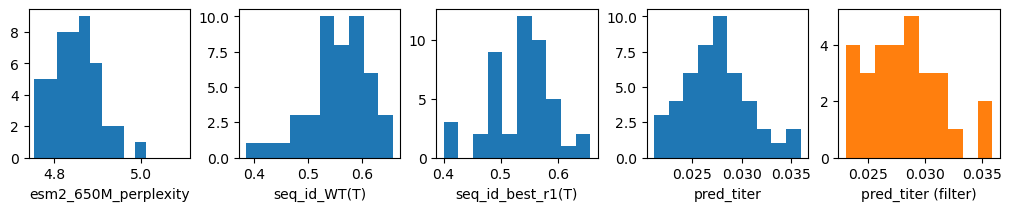

no of proteins for cluster 3.0: 77
no of proteins in cluster 3.0 with motif: 75
no of proteins for cluster 3.0 after filtering: 51
max titer before filter : 0.03467856977000003
max titer after filter : 0.03450878060000001
selected seq: gxps_ATC_evodiff_gen_155
esm2_650M_perplexity    4.829661
seq_id_WT(T)                 0.5
seq_id_best_r1(T)       0.571429
cluster_id                   3.0
pred_titer              0.034509
motif                       True
Name: gxps_ATC_evodiff_gen_155, dtype: object
T domain: GEVETQLAAIWEDLLGVERVGRHDNFFELGGHSLLIMRMMARLRQQGLLADVRTLVATPTIAAVAAALGS


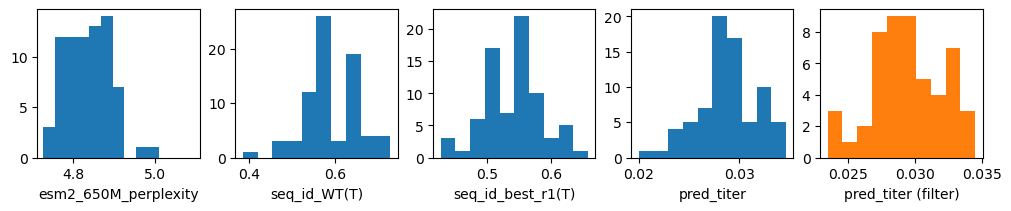

no of proteins for cluster 4.0: 79
no of proteins in cluster 4.0 with motif: 78
no of proteins for cluster 4.0 after filtering: 40
max titer before filter : 0.03900948814000003
max titer after filter : 0.03900948814000003
selected seq: gxps_ATC_evodiff_gen_21
esm2_650M_perplexity    4.796669
seq_id_WT(T)            0.642857
seq_id_best_r1(T)            0.6
cluster_id                   4.0
pred_titer              0.039009
motif                       True
Name: gxps_ATC_evodiff_gen_21, dtype: object
T domain: GELETALATIWCELLGVEPIGRHDNFFSLGGHSLLAVRMIEQLRQLGLQLAVRDLFQQPTLSDLAQRLQQ


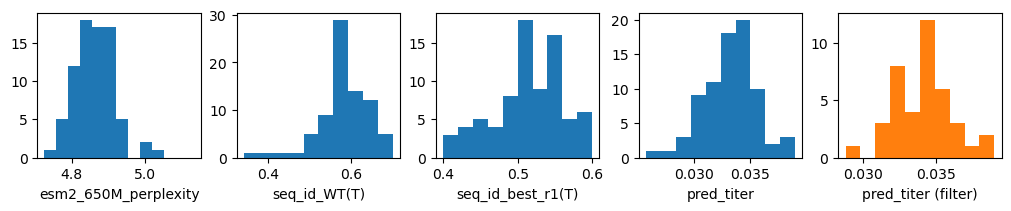

no of proteins for cluster 5.0: 1
no of proteins in cluster 5.0 with motif: 0
Skippping cluster 5.0
 
no of proteins for cluster 6.0: 73
no of proteins in cluster 6.0 with motif: 73
no of proteins for cluster 6.0 after filtering: 40
max titer before filter : 0.03876669422000003
max titer after filter : 0.03876669422000003
selected seq: gxps_ATC_evodiff_gen_88
esm2_650M_perplexity     4.81038
seq_id_WT(T)            0.642857
seq_id_best_r1(T)       0.557143
cluster_id                   6.0
pred_titer              0.038767
motif                       True
Name: gxps_ATC_evodiff_gen_88, dtype: object
T domain: DEVETTLAQIWQELLGVERVGRHDHFFALGGHSLLAVRLIERLHDRGMAISVRDLFQNPTLSALAESLMS


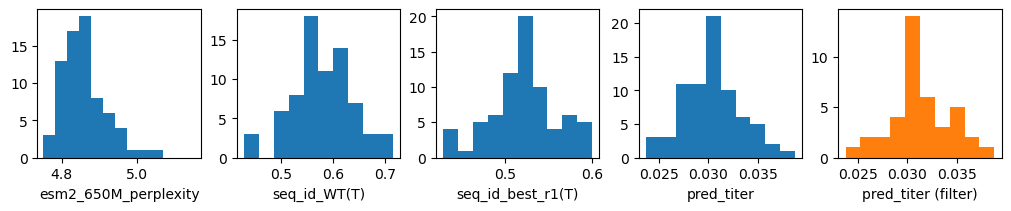

no of proteins for cluster 7.0: 70
no of proteins in cluster 7.0 with motif: 66
no of proteins for cluster 7.0 after filtering: 33
max titer before filter : 0.03628792402000001
max titer after filter : 0.03628792402000001
selected seq: gxps_ATC_evodiff_gen_189
esm2_650M_perplexity     4.81184
seq_id_WT(T)            0.657143
seq_id_best_r1(T)       0.514286
cluster_id                   7.0
pred_titer              0.036288
motif                       True
Name: gxps_ATC_evodiff_gen_189, dtype: object
T domain: GEIETTLATFWSELLGVEQVGRYDNFFTLGGHSLLTVRLIDRLRVLGLKADVRTLFQYPTLASLAQVLGT


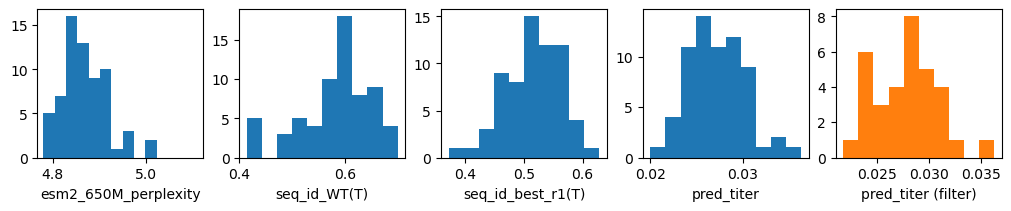

In [76]:
evodiff_selected = []
for c_idx in sorted(evodiff_meta['cluster_id'].unique()):
    mask = evodiff_meta['cluster_id'] == c_idx
    print(f'no of proteins for cluster {c_idx}: {mask.sum()}')
    mask = mask & (evodiff_meta['motif'])
    print(f'no of proteins in cluster {c_idx} with motif: {mask.sum()}')

    if mask.sum() < 1:
        print(f'Skippping cluster {c_idx}')
        print(' ')
        continue

    fig, ax = plt.subplots(1, 5, figsize=(10,2), layout='constrained')
    for _i, col in enumerate(['esm2_650M_perplexity', 'seq_id_WT(T)', 'seq_id_best_r1(T)', 'pred_titer']):
        ax[_i].hist(evodiff_meta.loc[mask, col])
        ax[_i].set_xlabel(col)
        if col == 'esm2_650M_perplexity':
            ax[_i].set_xlim(right=evodiff_meta.loc[mask, col].max()+0.1)

    perplexity_cutoff = 4.9
    _mask = mask & (evodiff_meta['esm2_650M_perplexity'] < perplexity_cutoff)
    _mask = _mask & ((evodiff_meta['seq_id_WT(T)'] > 0.45) & (evodiff_meta['seq_id_best_r1(T)'] > 0.5))
    print(f'no of proteins for cluster {c_idx} after filtering: {_mask.sum()}')

    ax[4].hist(evodiff_meta.loc[_mask, 'pred_titer'], color='tab:orange')
    ax[4].set_xlabel('pred_titer (filter)')

    print(f"max titer before filter : {evodiff_meta.loc[mask, 'pred_titer'].max()}")
    print(f"max titer after filter : {evodiff_meta.loc[_mask, 'pred_titer'].max()}")

    select = evodiff_meta.loc[_mask, 'pred_titer'].idxmax()
    print(f'selected seq: {select}')
    print(evodiff_meta.loc[select])
    print(f'T domain: {evodiff_proteins[select].get_residues(T_gxps_atc)}')

    evodiff_selected.append(select)

    plt.show()

In [77]:
evodiff_selected

['gxps_ATC_evodiff_gen_357',
 'gxps_ATC_evodiff_gen_77',
 'gxps_ATC_evodiff_gen_155',
 'gxps_ATC_evodiff_gen_21',
 'gxps_ATC_evodiff_gen_88',
 'gxps_ATC_evodiff_gen_189']

In [78]:
print(gxps_wt_protein.get_residues(T_gxps_atc))
print(round1_best_protein.get_residues(T_gxps_atc))
print(' ')
for i in evodiff_selected:
    print(evodiff_proteins[i].get_residues(T_gxps_atc))

GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP
GETEQLLAGIWMDLLQVDRVGRHDSFFELGGHSLLAVRLLGRLRQHGLGLQMRDLFEAPVLAELATRLRP
 
DAVETTLASIWSDLLNVEQVGRHDNFFALGGHSLLAVKLIERMRQADLQAAVSVLFNSSSLSALAQTLGS
GEMETQLAAIWQELLGLEQVGRHDNFFTLGGHSLLAVRLIERMRHVRLDVAVRTLFGSPTLADLATTLDT
GEVETQLAAIWEDLLGVERVGRHDNFFELGGHSLLIMRMMARLRQQGLLADVRTLVATPTIAAVAAALGS
GELETALATIWCELLGVEPIGRHDNFFSLGGHSLLAVRMIEQLRQLGLQLAVRDLFQQPTLSDLAQRLQQ
DEVETTLAQIWQELLGVERVGRHDHFFALGGHSLLAVRLIERLHDRGMAISVRDLFQNPTLSALAESLMS
GEIETTLATFWSELLGVEQVGRYDNFFTLGGHSLLTVRLIDRLRVLGLKADVRTLFQYPTLASLAQVLGT


In [85]:
evodiff_selected = [
 'gxps_ATC_evodiff_gen_357',
 'gxps_ATC_evodiff_gen_77',
 'gxps_ATC_evodiff_gen_155',
 'gxps_ATC_evodiff_gen_21',
 'gxps_ATC_evodiff_gen_88',
#  'gxps_ATC_evodiff_gen_189'
 ]

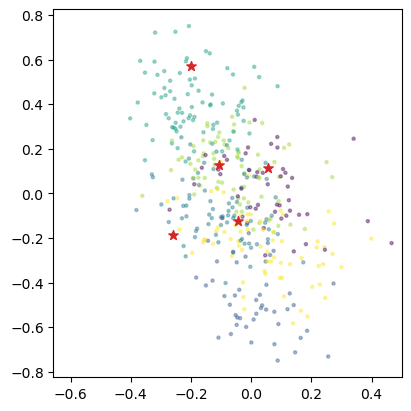

In [86]:
pca = PCA(n_components=2)

fig, ax = plt.subplots(1,1, figsize=(4,4), layout="constrained")
reduced_embeddings = pca.fit_transform(evodiff_embeddings)
ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=evodiff_meta['cluster_id'], alpha=0.4)
mask = evodiff_meta.index.isin(evodiff_selected)
ax.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], s=50, c='tab:red', marker='*')
ax.set_xlim(right=0.5)
plt.show()

In [87]:
# ## Save to fasta
# save_fasta_file = os.path.join(data_path, 'round_2.fasta')
# for rec_id in evodiff_selected:
#     print(rec_id)
#     helper.create_fasta({
#         rec_id: evodiff_proteins[rec_id].sequence
#     },
#     file=save_fasta_file,
#     append=True)

gxps_ATC_evodiff_gen_357
gxps_ATC_evodiff_gen_77
gxps_ATC_evodiff_gen_155
gxps_ATC_evodiff_gen_21
gxps_ATC_evodiff_gen_88


#### Fixing MPNN sequences with conserved motif -setup metadata

In [ ]:
# ## Get WildType Protein
# gxps_wt_seq = helper.read_fasta(os.path.join(gxps_path, 'GxpS_ATC.fasta'), mode='str')[0]
# gxps_wt_protein = BaseProtein(sequence=gxps_wt_seq, id='gxps_wt')

In [ ]:
# ## Get The best working protein
# round1_best_seq = helper.read_fasta(os.path.join(data_path, 'round1.best.fasta'), mode='str')[0]
# round1_best_protein = BaseProtein(sequence=round1_best_seq, id='round1.best')

In [ ]:
# ## Merging A and C domains to extraction of round 1 fasta
# records = helper.read_fasta(os.path.join(data_path, 'mpnn_motif_change_extraction.fasta'))
# for rec in records:
#     helper.create_fasta(sequences={
#         rec.id: gxps_wt_protein.get_residues(A_gxps_atc) + str(rec.seq) + gxps_wt_protein.get_residues(C_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'mpnn_motif_change.fasta'),
#     append=True)

In [ ]:
# ## Creating a fasta file of T domains
# records = helper.read_fasta(os.path.join(data_path, 'mpnn_motif_change.fasta'))
# for rec in records:
#     protein = BaseProtein(sequence=str(rec.seq), id=rec.id)
#     helper.create_fasta(sequences={
#         rec.id: protein.get_residues(T_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'mpnn_motif_change.T.fasta'),
#     append=True)

Perplexity calculation done in cluster

In [ ]:
# ## Seq ID to WT xgps and save to metadata
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(gxps_path, 'GxpS.T.fasta'),
#     gen = os.path.join(data_path, 'mpnn_motif_change.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )
# records = helper.read_fasta(os.path.join(data_path, 'mpnn_motif_change.fasta'))
# meta_file = os.path.join(os.path.join(data_path, 'mpnn_motif_change_metadata.json'))
# for rec, seq_id in zip(records, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_WT(T)', seq_id, force=False)

In [ ]:
# ## Seq ID to best round 1 seq and save to metadata
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(data_path, 'round1.best.T.fasta'),
#     gen = os.path.join(data_path, 'mpnn_motif_change.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )
# records = helper.read_fasta(os.path.join(data_path, 'mpnn_motif_change.fasta'))
# meta_file = os.path.join(os.path.join(data_path, 'mpnn_motif_change_metadata.json'))
# for rec, seq_id in zip(records, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_best_r1(T)', seq_id, force=False)

In [ ]:
# ## update pred titer to meta
# records = helper.read_fasta(os.path.join(data_path, 'mpnn_motif_change.fasta'))
# embeddings = get_embeddings_rec(records)
# pred_titer = model.predict(embeddings)

# meta_file = os.path.join(os.path.join(data_path, 'mpnn_motif_change_metadata.json'))
# assert len(records) == len(pred_titer)
# for rec, titer in zip(records, pred_titer):
#     helper.update_metadata_json(meta_file, rec.id, 'pred_titer', titer, force=False)

#### Fixing MPNN sequences with conserved motif - Analysis

In [88]:
mpnn_motif_change_fasta = os.path.join(data_path, 'mpnn_motif_change.fasta')
mpnn_motif_change_sequences = helper.read_fasta(mpnn_motif_change_fasta)

round_1_fasta = os.path.join(data_path, 'round_1.fasta')
round_1_sequences = helper.read_fasta(round_1_fasta)

In [89]:
with open(os.path.join(data_path, 'mpnn_motif_change_metadata.json')) as f:
    mpnn_motif_change_meta = json.load(f)
mpnn_motif_change_meta = pd.DataFrame(mpnn_motif_change_meta).T

with open(os.path.join(data_path, 'round_1_metadata.json')) as f:
    round_1_meta = json.load(f)
round_1_meta = pd.DataFrame(round_1_meta).T

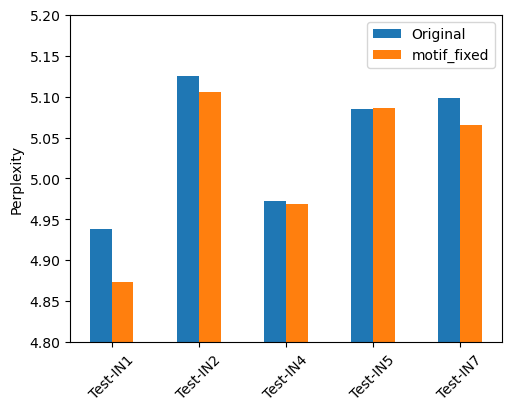

In [90]:
df_compare = round_1_meta[round_1_meta.index.isin([seq.split('-improved')[0] for seq in mpnn_motif_change_meta.index])]
df_compare = df_compare.sort_index()
mpnn_motif_change_meta = mpnn_motif_change_meta.sort_index()

labels = df_compare.index
x = np.arange(len(labels))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
ax.bar(x, df_compare['esm2_650M_perplexity'], width=0.25, label='Original')
ax.bar(x+0.25, mpnn_motif_change_meta['esm2_650M_perplexity'], width=0.25, label='motif_fixed')
ax.set_xticks(x+0.25/2, labels, rotation=45)
ax.set_ylabel('Perplexity')
ax.set_ylim(bottom=4.8, top=5.2)
ax.legend()

plt.show()

In [92]:
round_1_meta

,seq_id_WT(T),titer,esm2_650M_perplexity
PC-GxpS_ATC,1.000000,0.041675,4.775637
Test-ESM1,0.614286,0.032554,4.712609
Test-ESM2,0.542857,0.062307,4.715031
Test-ESM3,0.585714,0.003060,4.801270
Test-ESM4,0.571429,0.020002,4.732323
Test-IN1,0.542857,0.000000,4.938644
Test-IN2,0.542857,0.000000,5.125264
Test-IN3,0.557143,0.015385,4.926856
Test-IN4,0.414286,0.000000,4.972567
Test-IN5,0.442857,0.000000,5.084738


In [99]:
with open(os.path.join(data_path, 'll_guidance/ll_guidance_metadata.json')) as f:
    ll_guided_meta = json.load(f)
ll_guided_meta = pd.DataFrame(ll_guided_meta).T

In [106]:
round_2_fasta = os.path.join(data_path, 'round_2.fasta')
records = helper.read_fasta(round_2_fasta)

In [107]:
mpnn_motif_change_meta

,seq_id_WT(T),seq_id_best_r1(T),pred_titer,esm2_650M_perplexity
Test-IN1-improved,0.571429,0.614286,0.028641,4.873375
Test-IN2-improved,0.557143,0.471429,0.021036,5.105981
Test-IN4-improved,0.428571,0.557143,0.021084,4.968620
Test-IN5-improved,0.457143,0.485714,0.023828,5.085926
Test-IN7-improved,0.385714,0.500000,0.017753,5.065510


In [108]:
meta_concat = pd.concat([esm3_meta, esm3_str_meta, evodiff_meta, mpnn_motif_change_meta, ll_guided_meta])

In [109]:
rec_ids = []
for rec in records:
    rec_ids.append(rec.id)

In [110]:
meta_concat.loc[rec_ids]

,esm2_650M_perplexity,seq_id_WT(T),seq_id_best_r1(T),cluster_id,pred_titer,motif
gxps_ATC_esm3_temp_0.5_gen_385,4.667936,0.457143,0.542857,0.0,0.032752,True
gxps_ATC_esm3_temp_0.5_gen_93,4.645105,0.457143,0.514286,1.0,0.034949,True
gxps_ATC_esm3_temp_0.5_gen_192,4.638739,0.457143,0.557143,3.0,0.033070,True
gxps_ATC_esm3_temp_0.5_gen_17,4.687471,0.528571,0.514286,5.0,0.033171,True
gxps_ATC_esm3_temp_0.5_gen_333,4.609207,0.485714,0.585714,6.0,0.036807,True
gxps_ATC_esm3_str_temp_0.5_gen_323,4.658942,0.557143,0.671429,0.0,0.037323,True
gxps_ATC_esm3_str_temp_0.5_gen_365,4.656102,0.542857,0.728571,3.0,0.039676,True
gxps_ATC_esm3_str_temp_0.5_gen_314,4.602972,0.600000,0.700000,4.0,0.035986,True
gxps_ATC_esm3_str_temp_0.5_gen_53,4.649825,0.585714,0.771429,5.0,0.036999,True
gxps_ATC_esm3_str_temp_0.5_gen_170,4.610719,0.614286,0.642857,7.0,0.039617,True


In [113]:
# seq_dict = {}
# for rec in records:
#     seq_dict[rec.id] = ''.join([str(rec.seq)[i] for i in range(len(rec.seq)) if i not in A_gxps_atc+C_gxps_atc])
# helper.create_fasta(seq_dict, os.path.join(data_path, 'round_2.TplusL.fasta'))

In [112]:
# len(rec.seq)

1034

In [116]:
round_2_fasta = os.path.join(data_path, 'round_2.TplusL.fasta')
records = helper.read_fasta(round_2_fasta)
for rec in records:
    print(str(rec.seq))

APGHERDLGVAYVPPRTPLEQQLAEIWAELLGLDRVGVHDNFFELGGHSILAVQLMARVRTQLGVELPVRSLFETPTIAGLAARLQETGAVATASGPVRPAGHLQPDDLPLVDFG
QPDYTQLEQPYVAPDGDLEQQLAQLWADVLGVERVGRHDNFFDLGGHSILSIRLVSRIRSQLGVELPLRTLFDAPTVAELAQRIEQAPAAVTTGPRPIAGATSLTPDMLPLLDLS
APDNASLALAPYVAPRTPTEEVLAAIWADVLGLERVGIHDNFFELGGHSILATQVIARVRATFGLELPVRALFEAPTIAGLAARLDELTNTAAPAPLLPVVTTLTPGMVPLVTLS
IPDASTLPTAEYVAPRTEVEQTLAGIWAELLGVEQVGIHDNFFDLGGHSILAVQMIARIRTALGVDVPVRALFEAPTIAELATQVDQARPSTDLLAVEPQVATLTPDMLPLVTLS
QPDRAVLLEQAYVAPRTTLEEQLASIWSELLQRERVGIHDNFFELGGHSLLATQLIARIRSTFGVELPLRTLFEAPTIAELARRLEQAQPVASTVVPRPAQGRLTPAMLPLVALP
APDQAALFQRAYEAPSGEVELTLASIWQDLLQVDRVGRHDNFFDLGGHSLLAIQLLSRLRKRGWGLEARDLFEHPVLADLAQRVVPDTSTDAPAPLILPGRQHLTPDDLPLVTLS
APEAEQLATAAYVAPQGETEQLLAQIWQELLQVEQVGRQDNFFELGGHSLLAIQMLARLRQQGLALALRDLFEHPVLAELAERITPADDTAQRPALIAAGVTRLTPDHLPLVTLP
EPGPADLLSAAYQAPEGETETLLATIWQELLGVDRVGRQDNFFDLGGHSLLAVRLLSRLRRHGWGLALRDLFEHPVLAELAGRLTPADAPLPDAAPALSDATTLTPDMLPLVALT
APQAQDLIGQVYEAPEGETEQLLASIWQELLQVERVGRHDNFFDLGGHSLLAVRMLSRLRQHGLGLSLRSLF

In [8]:
ll_guidance_fasta = os.path.join(data_path, 'll_guidance/ll_guidance.fasta')
records = helper.read_fasta(ll_guidance_fasta)

In [10]:
import Levenshtein

In [12]:
dist_matrix = np.zeros((len(records), len(records)))
for i in range(len(records)):
    for j in range(i+1, len(records)):
        rec1 = records[i]
        seq1 = ''.join([str(rec1.seq)[k] for k in range(len(rec1.seq)) if k not in A_gxps_atc+C_gxps_atc])

        rec2 = records[j]
        seq2 = ''.join([str(rec2.seq)[k] for k in range(len(rec2.seq)) if k not in A_gxps_atc+C_gxps_atc])
        
        dist_matrix[i,j] = Levenshtein.distance(seq1, seq2)

In [13]:
dist_matrix

array([[ 0., 35., 34., 32., 38.],
       [ 0.,  0., 39., 23., 37.],
       [ 0.,  0.,  0., 39., 32.],
       [ 0.,  0.,  0.,  0., 38.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [ ]:
ll_guidance-ESM2
prob_guidance-ESM2
ll_guidance-WT
ll_guidance-ESM3
ll_guidance-IN2	